# Restructure Hazard Function Calculations

This notebook builds off of Marvin's work where I change the KaplanMeier Estimators to reflect days rather than years. Given that the lines are a bit difficult to read, I decided to report the values in the form of halflife estimates.

In [1]:
from datetime import timedelta, date
from pathlib import Path

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
import numpy as np
import pandas as pd
import plotnine as p9
import tqdm

from mizani.breaks import date_breaks
from mizani.formatters import timedelta_format

# Load the Data

In [2]:
published_dates = pd.read_csv(
    "../publication_delay_experiment/output/biorxiv_published_dates.tsv", sep="\t"
).assign(
    preprint_date=lambda x: pd.to_datetime(x.preprint_date.tolist()),
    published_date=lambda x: pd.to_datetime(
        x.published_date.apply(lambda y: y[0 : y.index(":")] if ":" in y else y)
    ),
)
print(published_dates.shape)
published_dates.head()

(44397, 7)


,biorxiv_doi,published_doi,preprint_title,preprint_category,preprint_date,published_date,published_citation_count
0,10.1101/001081,10.1093/bioinformatics/btu121,PyRAD: assembly of de novo RADseq loci for phy...,Bioinformatics,2013-12-03,2014-03-05,184
1,10.1101/001297,10.1371/journal.pone.0085203,Aerodynamic characteristics of a feathered din...,Biophysics,2013-12-10,2014-01-15,11
2,10.1101/000422,10.3389/fgene.2014.00013,On the optimal trimming of high-throughput mRN...,Bioinformatics,2013-11-14,2014-01-31,44
3,10.1101/001396,10.1162/NECO_a_00568,Parametric inference in the large data limit u...,Biophysics,2013-12-13,2014-03-10,4
4,10.1101/002980,10.1016/j.bpj.2014.01.012,Genetic drift suppresses bacterial conjugation...,Biophysics,2014-02-24,2014-02-18,10


In [3]:
biorxiv_journal_df = (
    pd.read_csv("../journal_tracker/output/mapped_published_doi.tsv", sep="\t")
    .groupby("preprint_doi")
    .agg(
        {
            "document": "first",
            "category": "first",
            "preprint_doi": "count",
            "published_doi": "first",
            "pmcid": "first",
            "pmcoa": "first",
            "posted_date": "first",
        }
    )
    .rename(index=str, columns={"preprint_doi": "version_count"})
    .reset_index()
)
print(biorxiv_journal_df.shape)
biorxiv_journal_df.head()

(71115, 8)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,posted_date
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,2013-11-07
1,10.1101/000042,000042_v1.xml,genomics,3,10.1038/nrg3723,PMC4151119,False,2013-11-07
2,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,2013-11-07
3,10.1101/000091,000091_v1.xml,synthetic biology,1,NaN,NaN,False,2013-11-07
4,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,2013-11-07


In [4]:
preprints_w_published_dates = (
    biorxiv_journal_df.sort_values("document")
    .merge(
        published_dates[["biorxiv_doi", "published_date"]].rename(
            index=str, columns={"biorxiv_doi": "preprint_doi"}
        ),
        on="preprint_doi",
        how="left",
    )
    .assign(published_date=lambda x: x.published_date.fillna(date.today()))
    .assign(
        time_to_published=lambda x: pd.to_datetime(x.published_date)
        - pd.to_datetime(x.posted_date)
    )
)
preprints_w_published_dates = preprints_w_published_dates[
    preprints_w_published_dates.time_to_published > pd.Timedelta(0)
].dropna()
print(preprints_w_published_dates.shape)
preprints_w_published_dates.head()

(30817, 10)


,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,posted_date,published_date,time_to_published
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,2013-11-07,2014-08-07 00:00:00,273 days
1,10.1101/000042,000042_v1.xml,genomics,3,10.1038/nrg3723,PMC4151119,False,2013-11-07,2014-06-01 00:00:00,206 days
2,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,2013-11-07,2014-02-27 00:00:00,112 days
4,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,2013-11-07,2014-06-26 00:00:00,231 days
5,10.1101/000125,000125_v1.xml,cancer biology,1,10.1016/j.ejca.2014.08.019,PMC4258103,False,2013-11-07,2014-10-08 00:00:00,335 days


# Calculate Overall Survival Function

This section loads up the KaplanMeier Estimator for preprints. It measures the lifetime of unpublished preprints. Overtime preprints start to become published which is what decreases the population size.

In [5]:
kmf = KaplanMeierFitter()

In [6]:
kmf.fit(
    preprints_w_published_dates["time_to_published"].dt.total_seconds() / 60 / 60 / 24,
    event_observed=~preprints_w_published_dates["published_doi"].isna(),
)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 30817 total observations, 0 right-censored observations>

In [7]:
kmf.median_survival_time_

170.0

In [8]:
median_ci = median_survival_times(kmf.confidence_interval_)
median_ci_l, median_ci_u = median_ci.values.flatten()
median_ci_l, median_ci_u

(169.0, 172.0)

In [9]:
overall_preprint_survival = kmf.survival_function_.reset_index().assign(
    label="all_papers"
)
overall_preprint_survival.head()

,timeline,KM_estimate,label
0,0.0,1.000000,all_papers
1,1.0,0.999351,all_papers
2,2.0,0.998215,all_papers
3,3.0,0.997144,all_papers
4,4.0,0.996333,all_papers


/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/scales/scale.py:611: PlotnineWarning: You have changed the transform of a specialised scale. The result may not be what you expect.
Original transform: pd_timedelta
New transform: pd_timedel
  PlotnineWarning
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


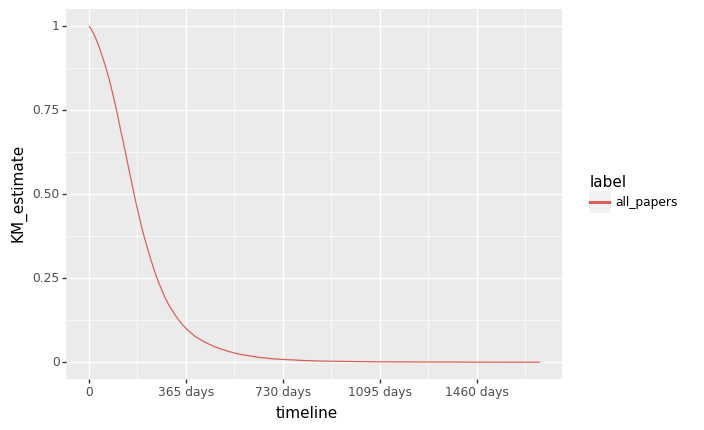

<ggplot: (8779068567132)>


In [10]:
g = (
    p9.ggplot(
        overall_preprint_survival.assign(
            timeline=lambda x: pd.to_timedelta(x.timeline, "D")
        ),
        p9.aes(x="timeline", y="KM_estimate", color="label"),
    )
    + p9.scale_x_timedelta(labels=timedelta_format("d"))
    + p9.geom_line()
    + p9.ylim(0, 1)
)
print(g)

# Calculate Category Survival Function

This section measures how long it takes for certain categories to get preprints published.

In [11]:
entire_preprint_df = pd.DataFrame([], columns=["timeline", "KM_estimate", "category"])
half_life = []
for cat, grouped_df in preprints_w_published_dates.groupby("category"):
    temp_df = preprints_w_published_dates.query(f"category=='{cat}'")
    kmf.fit(
        temp_df["time_to_published"].dt.total_seconds() / 60 / 60 / 24,
        event_observed=~temp_df["published_doi"].isna(),
    )

    median_ci = median_survival_times(kmf.confidence_interval_)
    median_ci_l, median_ci_u = median_ci.values.flatten()

    half_life.append(
        {
            "category": cat,
            "half_life_time": kmf.median_survival_time_,
            "half_life_ci_l": median_ci_l,
            "half_life_ci_u": median_ci_u,
        }
    )

    entire_preprint_df = entire_preprint_df.append(
        kmf.survival_function_.reset_index().assign(category=cat)
    )

/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/scales/scale.py:611: PlotnineWarning: You have changed the transform of a specialised scale. The result may not be what you expect.
Original transform: pd_timedelta
New transform: pd_timedel
  PlotnineWarning
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/preprint_category_survival_curves.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from

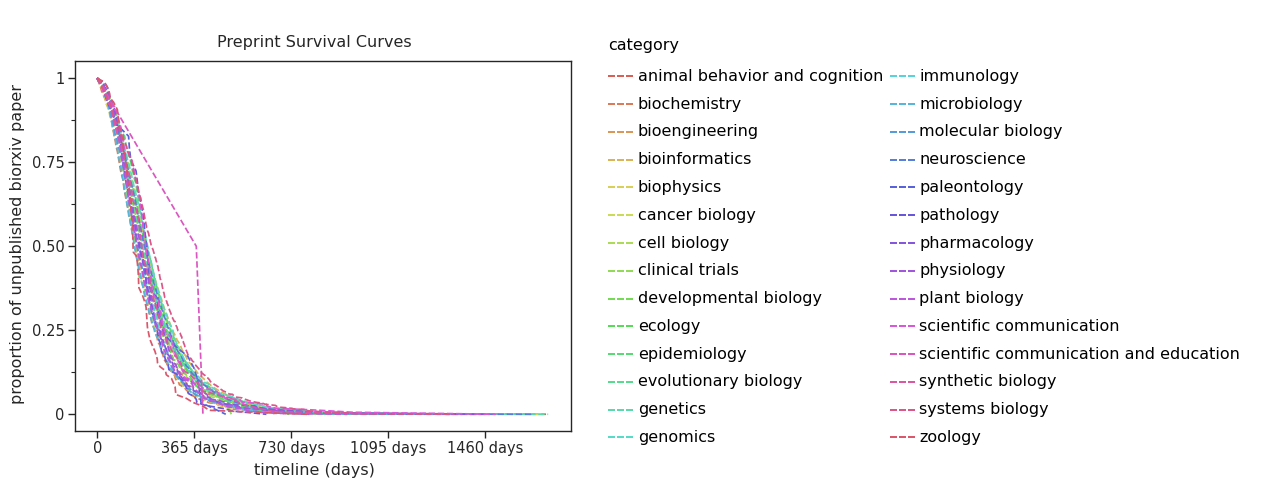

<ggplot: (8779068217720)>


In [12]:
g = (
    p9.ggplot(
        entire_preprint_df.assign(
            timeline=lambda x: pd.to_timedelta(x.timeline, "D")
        ).query("category != 'none'"),
        p9.aes(x="timeline", y="KM_estimate", color="category"),
    )
    + p9.geom_line(linetype="dashed", size=0.7)
    + p9.ylim(0, 1)
    + p9.scale_x_timedelta(labels=timedelta_format("d"))
    + p9.labs(
        x="timeline (days)",
        y="proportion of unpublished biorxiv paper",
        title="Preprint Survival Curves",
    )
    + p9.theme_seaborn(context="paper", style="white", font_scale=1.2)
    + p9.theme(
        axis_ticks_minor_x=p9.element_blank(),
        # legend_position=(0.5, -0.2),
        # legend_direction='horizontal'
    )
)
g.save("output/preprint_category_survival_curves.svg", dpi=500)
g.save("output/preprint_category_survival_curves.png", dpi=500)
print(g)

In [13]:
category_half_life = pd.DataFrame.from_records(half_life).replace(
    np.inf, (temp_df["time_to_published"].dt.total_seconds() / 60 / 60 / 24).max()
)
category_half_life

,category,half_life_time,half_life_ci_l,half_life_ci_u
0,animal behavior and cognition,159.0,147.0,175.0
1,biochemistry,142.0,136.0,151.0
2,bioengineering,166.0,154.0,180.0
3,bioinformatics,186.0,181.0,192.0
4,biophysics,146.0,140.0,154.0
5,cancer biology,183.0,173.0,193.0
6,cell biology,171.0,165.0,176.0
7,clinical trials,146.0,111.0,203.0
8,developmental biology,165.0,160.0,174.0
9,ecology,182.0,172.0,190.0


/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/scales/scale.py:611: PlotnineWarning: You have changed the transform of a specialised scale. The result may not be what you expect.
Original transform: pd_timedelta
New transform: pd_timedel
  PlotnineWarning
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/preprint_category_halflife.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/thielk/envs/misc/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/preprint_category_halflife.png
  warn('Filename: {}'.format(filename), Plotni

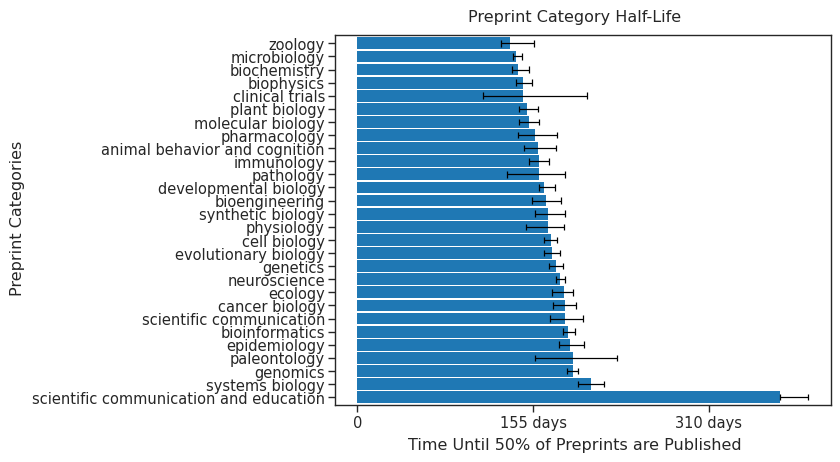

<ggplot: (-9223363257786792739)>


In [14]:
g = (
    p9.ggplot(
        category_half_life.query("category!='none'").assign(
            half_life_time=lambda x: pd.to_timedelta(x.half_life_time, "D"),
            half_life_ci_l=lambda x: pd.to_timedelta(x.half_life_ci_l, "D"),
            half_life_ci_u=lambda x: pd.to_timedelta(x.half_life_ci_u, "D"),
        ),
        p9.aes(x="category", y="half_life_time", ymin="half_life_ci_l", ymax="half_life_ci_u"),
    )
    + p9.geom_col(fill="#1f78b4")
    + p9.geom_errorbar()
    + p9.scale_x_discrete(
        limits=(
            category_half_life.query("category!='none'")
            .sort_values("half_life_time")
            .category.tolist()[::-1]
        ),
    )
    + p9.scale_y_timedelta(labels=timedelta_format("d"))
    + p9.coord_flip()
    + p9.labs(
        x="Preprint Categories",
        y="Time Until 50% of Preprints are Published",
        title="Preprint Category Half-Life",
    )
    + p9.theme_seaborn(context="paper", style="white", font_scale=1.2)
    + p9.theme(axis_ticks_minor_x=p9.element_blank(),)
)
g.save("output/preprint_category_halflife.svg", dpi=250)
g.save("output/preprint_category_halflife.png", dpi=250)
print(g)

Take home Results:
    1. The average amount of time for half of all preprints to be published is 348 days (~1 year)
    2. Biophysics and biochemistry are two categories that take the least time to have half their preprints published